# Temperature Scaling in Softmax: The Mathematics

Temperature scaling modifies the softmax function to control the "sharpness" of the probability distribution. The standard softmax function is:

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

With temperature scaling, we introduce a temperature parameter $T$:

$$\text{softmax}_T(x_i) = \frac{e^{x_i/T}}{\sum_{j=1}^{n} e^{x_j/T}}$$

## Effects of Temperature:

- **T = 1**: Standard softmax (no scaling)
- **T > 1**: Higher temperature → More uniform distribution → More randomness
- **T < 1**: Lower temperature → Sharper distribution → More deterministic
- **T → 0**: Distribution becomes one-hot (argmax)
- **T → ∞**: Distribution becomes uniform

## Entropy and Diversity:
The entropy of a probability distribution measures its randomness:
$$H(p) = -\sum_{i=1}^{n} p_i \log p_i$$

Higher temperature typically leads to higher entropy and more diverse outputs.

## Imports and Setup

Let's import the necessary libraries and set up our environment:

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from scipy.stats import entropy

# Rich imports for better formatting
from rich.console import Console
from rich.table import Table
from rich.text import Text
from rich import print as rprint

# Initialize rich console
console = Console()

All necessary libraries loaded for language modeling, visualization, and rich formatting.

## Visual Demonstration

Let's create a visual diagram showing how temperature affects probability distributions:

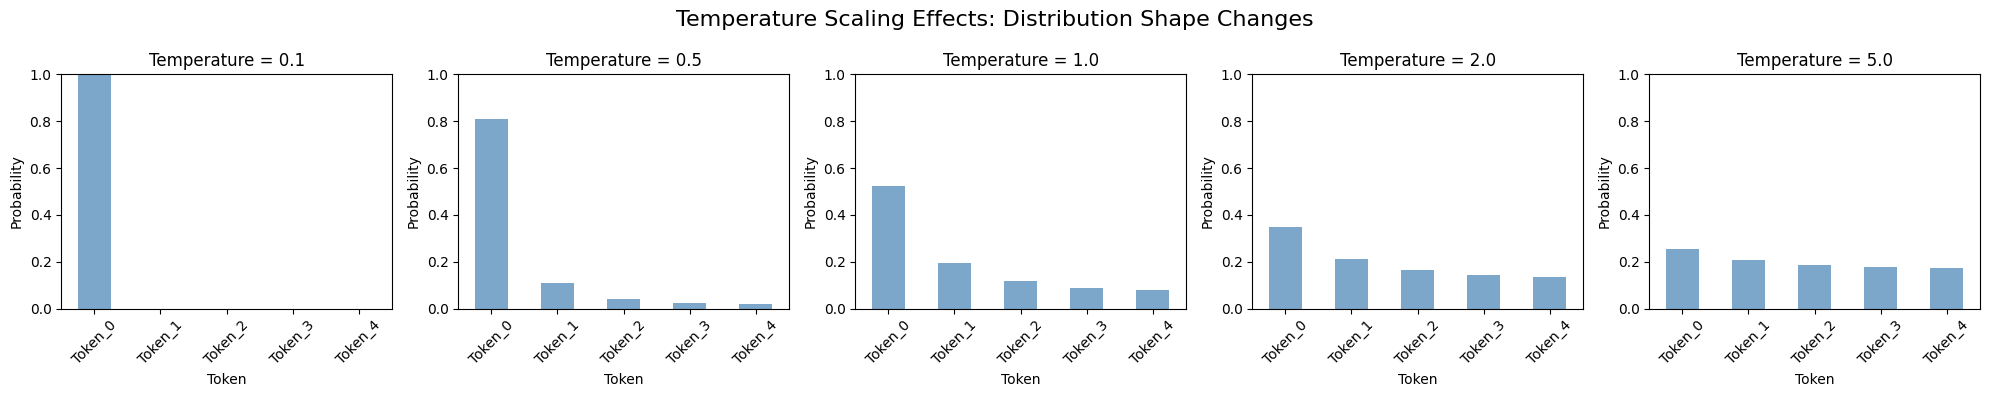

In [2]:
# Create sample logits and temperature ranges
logits = np.array([2.0, 1.0, 0.5, 0.2, 0.1])
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]

# Create subplots to show each temperature's distribution
fig, axes = plt.subplots(1, len(temperatures), figsize=(20, 4))

for i, temp in enumerate(temperatures):
    # Calculate probabilities for this temperature
    scaled_logits = logits / temp
    probs = np.exp(scaled_logits) / np.sum(np.exp(scaled_logits))
    
    # Create DataFrame for this temperature
    df_temp = pd.DataFrame({
        'Token': [f'Token_{j}' for j in range(len(logits))],
        'Probability': probs
    })
    
    # Plot distribution for this temperature
    df_temp.plot(x='Token', y='Probability', kind='bar', ax=axes[i], 
                 color='steelblue', alpha=0.7, legend=False)
    axes[i].set_title(f'Temperature = {temp}')
    axes[i].set_ylabel('Probability')
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Temperature Scaling Effects: Distribution Shape Changes', fontsize=16)
plt.tight_layout()
plt.show()

This diagram clearly shows how temperature reshapes probability distributions - low temperatures create peaked distributions while high temperatures flatten them.

## Model Setup

Load a language model to explore temperature effects in practice:

In [3]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Set padding token to avoid warnings
tokenizer.pad_token = tokenizer.eos_token

DistilGPT2 loaded with proper tokenizer configuration.

## Example Prompt

Let's start with a simple prompt to analyze:

In [4]:
prompt = "In the future, AI will"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
print("Input IDs:", input_ids)
print("Vocabulary size:", model.config.vocab_size)

Input IDs: tensor([[ 818,  262, 2003,   11, 9552,  481]])
Vocabulary size: 50257


The model converts text to token IDs and works with a vocabulary of 50,257 tokens.

## Text Generation with Low Temperature

Generate text with very low temperature to see deterministic behavior:

In [5]:
output = model.generate(
    input_ids,
    do_sample=True,
    temperature=0.01,
    max_new_tokens=20,
    top_k=50,
    pad_token_id=tokenizer.eos_token_id,
    attention_mask=torch.ones_like(input_ids)
)

decoded = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated text:", decoded)

Generated text: In the future, AI will be able to do things like make people smarter, more intelligent, more intelligent, more intelligent, more


Low temperature produces repetitive, deterministic text.

## Logits Analysis

Let's examine the raw logits and probabilities for next token prediction:

In [6]:
# Get the logits for prediction
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits
    # Show logits and probabilities for top 10 tokens
    top_logits, top_indices = torch.topk(logits[0, -1], k=10)
    top_probs = torch.softmax(top_logits, dim=0)
    top_tokens = [tokenizer.decode([idx]) for idx in top_indices]
    
    # Create a clean table
    table = Table(title="Top 10 Token Predictions")
    table.add_column("Rank", style="dim")
    table.add_column("Token", style="cyan")
    table.add_column("Logit", style="magenta")
    table.add_column("Probability", style="green")
    
    for i, (token, logit, prob) in enumerate(zip(top_tokens, top_logits, top_probs)):
        table.add_row(
            str(i + 1),
            repr(token),
            f"{logit.item():.4f}",
            f"{prob.item():.4f}"
        )
    
    console.print(table)

           Top 10 Token Predictions            
┏━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Rank ┃ Token       ┃ Logit    ┃ Probability ┃
┡━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ 1    │ ' be'       │ -63.5934 │ 0.5269      │
│ 2    │ ' have'     │ -64.7306 │ 0.1690      │
│ 3    │ ' need'     │ -65.5254 │ 0.0763      │
│ 4    │ ' become'   │ -65.8555 │ 0.0549      │
│ 5    │ ' not'      │ -66.0847 │ 0.0436      │
│ 6    │ ' also'     │ -66.4207 │ 0.0312      │
│ 7    │ ' take'     │ -66.5617 │ 0.0271      │
│ 8    │ ' continue' │ -66.5808 │ 0.0266      │
│ 9    │ ' make'     │ -66.6369 │ 0.0251      │
│ 10   │ ' only'     │ -66.8984 │ 0.0193      │
└──────┴─────────────┴──────────┴─────────────┘

The model shows clear preference for certain tokens, with "be" having the highest probability.

## Token Sampling

Sample tokens from the probability distribution to see randomness in action:

In [7]:
# Sample tokens from the distribution
sampled_indices = torch.multinomial(top_probs, num_samples=100, replacement=True)
sampled_tokens = [top_tokens[idx] for idx in sampled_indices]
print("Sample of tokens:", sampled_tokens[:20])

# Count occurrences
token_counts = Counter(sampled_tokens)
print("\nToken counts from 100 samples:")
for token, count in token_counts.most_common():
    print(f"Token: {token}, Count: {count}")

Sample of tokens: [' not', ' be', ' be', ' be', ' be', ' become', ' be', ' have', ' be', ' be', ' need', ' have', ' be', ' be', ' be', ' be', ' make', ' be', ' need', ' be']

Token counts from 100 samples:
Token:  be, Count: 55
Token:  have, Count: 14
Token:  become, Count: 8
Token:  need, Count: 8
Token:  make, Count: 4
Token:  not, Count: 3
Token:  take, Count: 2
Token:  also, Count: 2
Token:  continue, Count: 2
Token:  only, Count: 2


Token counts from 100 samples reflect the underlying probability distribution.

## Temperature Scaling Comparison

Compare extreme temperature values to see dramatic differences:

In [8]:
# Temperature scaling comparison
high_temperature = 100.0
low_temperature = 0.01

scaled_logits_high = logits / high_temperature
scaled_logits_low = logits / low_temperature

# Get top 10 tokens for each temperature
top_logits_high, top_indices_high = torch.topk(scaled_logits_high[0, -1], k=10)
top_probs_high = torch.softmax(top_logits_high, dim=0)
top_tokens_high = [tokenizer.decode([idx]) for idx in top_indices_high]

top_logits_low, top_indices_low = torch.topk(scaled_logits_low[0, -1], k=10)
top_probs_low = torch.softmax(top_logits_low, dim=0)
top_tokens_low = [tokenizer.decode([idx]) for idx in top_indices_low]

# Create comparison table
table = Table(title="Temperature Scaling Comparison")
table.add_column("Rank", style="dim")
table.add_column("Token", style="cyan")
table.add_column("High T (100.0)", style="green")
table.add_column("Low T (0.01)", style="red")

for i in range(10):
    table.add_row(
        str(i + 1),
        repr(top_tokens_high[i]),
        f"{top_probs_high[i].item():.4f}",
        f"{top_probs_low[i].item():.4f}"
    )

console.print(table)

            Temperature Scaling Comparison            
┏━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Rank ┃ Token       ┃ High T (100.0) ┃ Low T (0.01) ┃
┡━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 1    │ ' be'       │ 0.1023         │ 1.0000       │
│ 2    │ ' have'     │ 0.1012         │ 0.0000       │
│ 3    │ ' need'     │ 0.1004         │ 0.0000       │
│ 4    │ ' become'   │ 0.1000         │ 0.0000       │
│ 5    │ ' not'      │ 0.0998         │ 0.0000       │
│ 6    │ ' also'     │ 0.0995         │ 0.0000       │
│ 7    │ ' take'     │ 0.0993         │ 0.0000       │
│ 8    │ ' continue' │ 0.0993         │ 0.0000       │
│ 9    │ ' make'     │ 0.0992         │ 0.0000       │
│ 10   │ ' only'     │ 0.0990         │ 0.0000       │
└──────┴─────────────┴────────────────┴──────────────┘

High temperature creates uniform distribution while low temperature creates deterministic selection.

## Temperature Analysis

Analyze how different temperatures affect probability distributions and entropy:

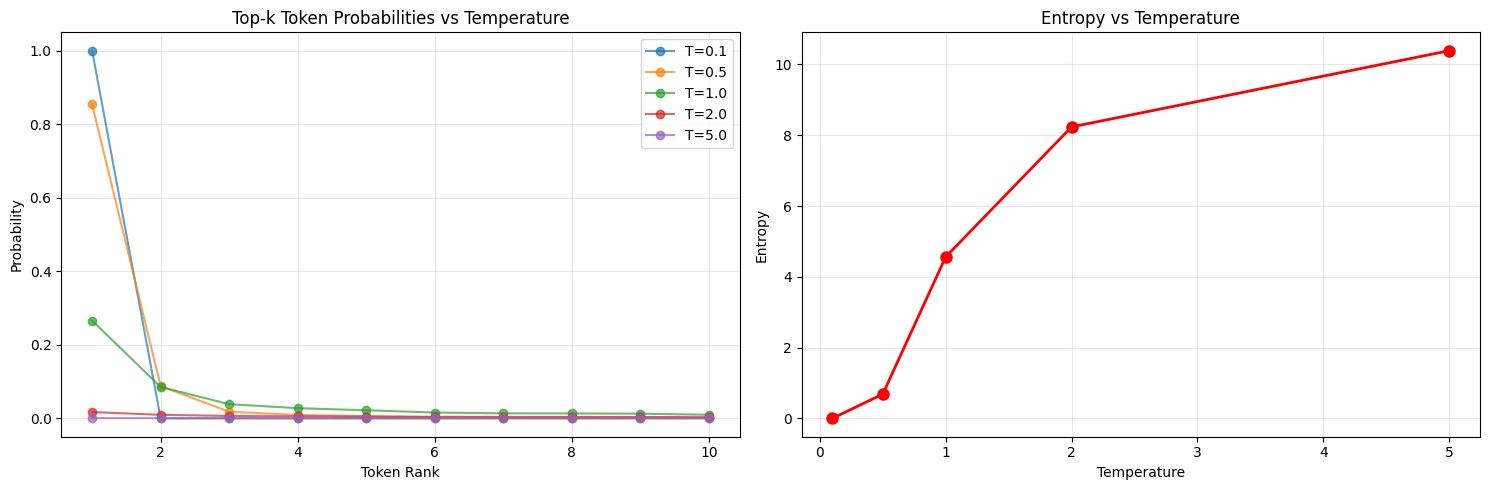

In [9]:
# Function to analyze temperature effects
def analyze_temperature_effects(logits, temperatures, top_k=10):
    results = []
    for temp in temperatures:
        scaled_logits = logits / temp
        probs = torch.softmax(scaled_logits, dim=-1)
        
        # Get top-k tokens
        top_probs, top_indices = torch.topk(probs[0, -1], k=top_k)
        top_tokens = [tokenizer.decode([idx]) for idx in top_indices]
        
        # Calculate entropy
        prob_dist = probs[0, -1].cpu().numpy()
        entropy_value = entropy(prob_dist)
        
        for i, (token, prob) in enumerate(zip(top_tokens, top_probs)):
            results.append({
                'temperature': temp,
                'token': token,
                'probability': prob.item(),
                'rank': i + 1,
                'entropy': entropy_value
            })
    
    return results

# Test with different temperature values
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]
results = analyze_temperature_effects(logits, temperatures)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Top-k probabilities
for temp in temperatures:
    temp_data = [r for r in results if r['temperature'] == temp]
    ranks = [r['rank'] for r in temp_data]
    probs = [r['probability'] for r in temp_data]
    axes[0].plot(ranks, probs, 'o-', label=f'T={temp}', alpha=0.7)

axes[0].set_xlabel('Token Rank')
axes[0].set_ylabel('Probability')
axes[0].set_title('Top-k Token Probabilities vs Temperature')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Entropy vs Temperature
entropies = []
for temp in temperatures:
    temp_entropy = [r['entropy'] for r in results if r['temperature'] == temp][0]
    entropies.append(temp_entropy)

axes[1].plot(temperatures, entropies, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Temperature')
axes[1].set_ylabel('Entropy')
axes[1].set_title('Entropy vs Temperature')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Higher temperatures lead to flatter distributions and higher entropy, confirming the mathematical relationship.

## Diverse Examples Across Domains

Test temperature effects on different types of content:

In [10]:
def generate_comparison_examples():
    """Generate examples across different domains to show temperature effects"""
    
    examples = [
        ("The scientific method involves", "Science"),
        ("To solve the equation x^2 - 4x + 3 = 0,", "Mathematics"),
        ("In Shakespeare's time, the theater", "Literature/English")
    ]
    
    temperatures = [0.3, 1.0, 2.0]
    
    for prompt, domain in examples:
        rprint(f"\n[bold]{domain.upper()}[/bold]")
        rprint(f"Prompt: '{prompt}'")
        rprint("-" * 50)
        
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        
        for temp in temperatures:
            rprint(f"\n[cyan]Temperature {temp}:[/cyan]")
            for i in range(3):  # Generate 3 samples per temperature
                output = model.generate(
                    input_ids,
                    do_sample=True,
                    temperature=temp,
                    max_new_tokens=15,
                    top_k=50,
                    pad_token_id=tokenizer.eos_token_id,
                    attention_mask=torch.ones_like(input_ids)
                )
                
                generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
                new_text = generated_text[len(prompt):].strip()
                rprint(f"  Sample {i+1}: {new_text}")
        
        print()

generate_comparison_examples()

SCIENCE

Prompt: 'The scientific method involves'

--------------------------------------------------

Temperature 0.3:

Sample 1: a series of experiments and experiments that are conducted to determine the properties of the

Sample 2: the use of a number of different methods to determine the exact number of atoms

Sample 3: the use of a single-digit number to identify the source of the source

Temperature 1.0:

Sample 1: using a method called in realtime to estimate the frequency or frequency of incoming

Sample 2: changing every element of the cell's genome to an arbitrary set of mutations in

Sample 3: the formation and construction of a crystal. The following steps include:

Temperature 2.0:

Sample 1: examining chemical reactions among humans through blood alcohol level (admittedly much of its

Sample 2: evaluating a number or finding something relevant or useful.

Sample 3: a selection task whereby each candidate learns a standard for scientific knowledge concerning what type

MATHEMATICS

Prompt: 'To solve the equation x^2 - 4x + 3 = 0,'

--------------------------------------------------

Temperature 0.3:

Sample 1: x^2 - 4x + 3 = 0, x^2 -

Sample 2: x^2 + 4 = 0, x^2 + 4 = 0

Sample 3: x^2 = 0, x^2 = 0, x^2

Temperature 1.0:

Sample 1: + 1 = 0, + 2 = 0, + 2 = 0,

Sample 2: 3 = 3, 3 = 2, 3 = 4, 4 = 4

Sample 3: 0 / 2 ^ 3 = 12x2 + 5 = 11 x =

Temperature 2.0:

Sample 1: (q<sqrt({-3x_{x-1} =

Sample 2: 0x4 - 6x *(s)} .


Here there

Sample 3: x / the given equation [ 1 ];
But as they move across these

LITERATURE/ENGLISH

Prompt: 'In Shakespeare's time, the theater'

--------------------------------------------------

Temperature 0.3:

Sample 1: was a place where people could play Shakespeare, and Shakespeare was a place where

Sample 2: was a sort of theater where the audience could be seen and heard.

Sample 3: was a kind of theater, a kind of theater that was a kind of

Temperature 1.0:

Sample 1: set itself on fire when a drunk man threw the gas on his stomach in

Sample 2: is one of the few in the world that can create a musical experience.

Sample 3: can still hold you together with laughter, even if you're in need of

Temperature 2.0:

Sample 1: made its premiere in the 19th century from 1718 and made international,

Sample 2: house itself might become known on Saturday night: as William E. Bennett is

Sample 3: has long been synonymous with the modern "good-quality" arts -- where

Multiple samples reveal consistency patterns at low temperatures and diversity at high temperatures across all domains.

# Practical Applications

## Use Cases
- **Low Temperature (0.1-0.5)**: Code generation, technical docs, factual content
- **Medium Temperature (0.7-1.2)**: Creative writing, chatbots, general text
- **High Temperature (1.5-3.0)**: Brainstorming, fiction, diverse idea generation

## Quick Guidelines
- Start with T=1.0 as baseline
- Lower temperature for consistency and accuracy
- Higher temperature for creativity and diversity

# Conclusion

Temperature scaling is a simple yet powerful technique for controlling language model randomness:

- **T < 1**: More deterministic, consistent outputs
- **T = 1**: Standard softmax behavior  
- **T > 1**: More random, diverse outputs

Monitor entropy to quantify diversity. Temperature remains one of the most practical tools for controlling LLM behavior.

# References

## Code and Implementation
- Temperature Scaling Repository: https://github.com/gpleiss/temperature_scaling
- Twitter Discussion: https://x.com/akshay_pachaar/status/1942201076767412307

## Academic Sources
- Hinton, G. et al. (2015): "Distilling the Knowledge in a Neural Network" - Original paper introducing temperature in knowledge distillation
- Guo, C. et al. (2017): "On Calibration of Modern Neural Networks" - ICML paper on temperature scaling for calibration
- Goodfellow, I. et al. (2016): "Deep Learning" - Chapter 6 covers softmax and temperature scaling
- Bishop, C. (2006): "Pattern Recognition and Machine Learning" - Chapter 4 discusses softmax temperature

## Textbooks
- "Deep Learning" by Goodfellow, Bengio, and Courville - Comprehensive coverage of softmax and sampling techniques
- "Pattern Recognition and Machine Learning" by Christopher Bishop - Mathematical foundations of probability distributions
- "The Elements of Statistical Learning" by Hastie, Tibshirani, and Friedman - Statistical perspective on temperature scaling